<a href="https://colab.research.google.com/github/novoforce/Exploring-Tensorflow/blob/main/mnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [2]:
#create tuples for getting the train and test images
(train_images,train_labels),(test_images,test_labels)= tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


The label of the below image is:  5


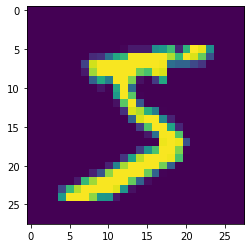

In [3]:
#plotting an example from the train images
print("The label of the below image is: ",train_labels[0])
plt.imshow(train_images[0])

In [4]:
print(train_images[0],'and the shape of the train_image is: ',train_images[0].shape)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

In [5]:
train_images= train_images.reshape(train_images.shape[0],28,28,1) #(60000,28,28,1)

In [6]:
train_images= (train_images-127.5)/127.5 #normalization

train_images[0]

array([[[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [

In [7]:
BUFFER_SIZE= train_images.shape[0]
BATCH_SIZE= 100
train_dataset= tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Discriminator
This is same as a categorical model. It will basically a binary classifier as its job is to find whether the image is real or fake

In [8]:
def make_discriminator_model():
  model= tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(7,(3,3),padding='same',input_shape=(28,28,1)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dense(50,activation='relu'))
  model.add(tf.keras.layers.Dense(1))
  model.summary()
  return model

In [9]:
discriminator= make_discriminator_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 7)         70        
_________________________________________________________________
flatten (Flatten)            (None, 5488)              0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5488)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                274450    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 274,571
Trainable params: 274,571
Non-trainable params: 0
_________________________________________________________________


In [10]:
#pass some data and check
discriminator(np.random.rand(1,28,28,1).astype('float32'))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.06293635]], dtype=float32)>

In [11]:
discriminator_optimizer= tf.optimizers.Adam(1e-3)

In [12]:
def get_diriminator_loss(real_predictions,fake_predictions):
  real_predictions= tf.sigmoid(real_predictions) #so as to between 0 and 1
  fake_predictions= tf.sigmoid(fake_predictions) #so as to between 0 and 1
  real_loss= tf.losses.binary_crossentropy(tf.ones_like(real_predictions),real_predictions)
  fake_loss= tf.losses.binary_crossentropy(tf.zeros_like(fake_predictions),fake_predictions)
  return real_loss + fake_loss

# Generator

In [13]:
def make_generator_model():
  model= tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(7*7*256,input_shape=(100,))) #since we need to upsample to 28*28 so we are taking 7*7 and will upsampling.
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Reshape((7,7,256))) #7*7
  model.add(tf.keras.layers.Conv2DTranspose(128,(3,3),padding='same'))#7*7
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding='same'))#14*14
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2DTranspose(1,(3,3),strides=(2,2),padding='same'))#28*28
  model.summary()
  return model

In [14]:
generator= make_generator_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         295040    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)       

In [15]:
def get_generator_loss(fake_predictions):
  fake_predictions= tf.sigmoid(fake_predictions)
  fake_loss= tf.losses.binary_crossentropy(tf.ones_like(fake_predictions),fake_predictions)
  return fake_loss

In [16]:
generator_optimizer= tf.optimizers.Adam(1e-4)

# Training

In [17]:
def train(dataset,epochs):
  for _ in range(epochs):
    for images in dataset:
      images= tf.cast(images,tf.dtypes.float32)
      train_step(images)

In [24]:
def train_step(images):
  fake_image_noise= np.random.randn(BATCH_SIZE,100).astype("float32")
  with tf.GradientTape() as gen_tape, tf.GradientTape() as desc_tape:
    generated_images= generator(fake_image_noise)
    real_output= discriminator(images)
    fake_output= discriminator(generated_images)

    gen_loss= get_generator_loss(fake_output)
    disc_loss= get_diriminator_loss(real_output,fake_output)

    gradients_of_generator= gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator= desc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

    print("generator_loss: ",np.mean(gen_loss))
    print("discriminator_loss: ",np.mean(disc_loss))

In [29]:
train(train_dataset,20)

Streaming output truncated to the last 5000 lines.
discriminator_loss:  0.008115516
generator_loss:  13.198923
discriminator_loss:  0.032068163
generator_loss:  13.069942
discriminator_loss:  0.061262526
generator_loss:  13.952153
discriminator_loss:  0.0020752803
generator_loss:  12.775043
discriminator_loss:  0.006118924
generator_loss:  14.018236
discriminator_loss:  0.002125761
generator_loss:  13.33625
discriminator_loss:  0.029123805
generator_loss:  13.547131
discriminator_loss:  0.016882466
generator_loss:  14.174884
discriminator_loss:  0.0018665249
generator_loss:  13.229434
discriminator_loss:  0.008861162
generator_loss:  13.808155
discriminator_loss:  0.005423346
generator_loss:  13.561173
discriminator_loss:  0.055984605
generator_loss:  13.182903
discriminator_loss:  0.057928983
generator_loss:  13.0475235
discriminator_loss:  0.037455656
generator_loss:  12.315431
discriminator_loss:  0.035109617
generator_loss:  12.891296
discriminator_loss:  0.012743673
generator_loss

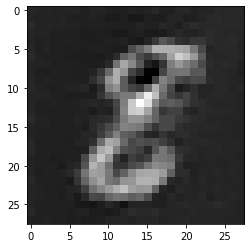

In [36]:
plt.imshow(tf.reshape(generator(np.random.randn(1,100)),(28,28)),cmap='gray')